# Multi-layer perceptron

In [36]:
## If problems arise with the loading of the shared library, this script can be used to load the shared library before other libraries.
## Remember to also run on your local machine the script below:
# bash replace_lib_version.sh

import platform
import ctypes

# if platform.system() == "Linux":
#     # Force libgomp to be loaded before other libraries consuming dynamic TLS (to avoid running out of STATIC_TLS)
#     ctypes.cdll.LoadLibrary("libgomp.so.1")
#     ctypes.cdll.LoadLibrary(
#         "/home/vscode/.local/lib/python3.12/site-packages/py_nillion_client/py_nillion_client.abi3.so"
#     )

In [37]:
import os
import sys

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
print(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
import json
import nada_numpy as na
import numpy as np
import py_nillion_client as nillion
import torch
from common.utils import store_program, store_secrets
from cosmpy.aerial.client import LedgerClient
from cosmpy.aerial.wallet import LocalWallet
from cosmpy.crypto.keypairs import PrivateKey
from dotenv import load_dotenv
from nada_ai.client import TorchClient
from nillion_python_helpers import (create_nillion_client,
                                    create_payments_config)
from py_nillion_client import NodeKey, UserKey

from torch import nn
from torchvision import transforms
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_recall_fscore_support,
)
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

home = os.getenv("HOME")
load_dotenv(f"{home}/.config/nillion/nillion-devnet.env")

/home/brglt/Desktop/nillion/quickstart/nada_quickstart_programs


True

In [38]:
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset

# Data preprocessing and augmentation

In [ ]:
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


train_dataset = ImageFolder('/content/Training', transform=data_transforms)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

val_dataset = ImageFolder('/content/Testing', transform=data_transforms)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Load a batch of images and labels for visualization

In [ ]:
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Convert images to numpy arrays and denormalize
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
images = (images.numpy().transpose((0, 2, 3, 1)) * std + mean).clip(0, 1)

# Create a grid of images
num_images = len(images)
rows = int(np.ceil(num_images / 4))
fig, axes = plt.subplots(rows, 4, figsize=(15, 15))

# Plot images with labels
for i, ax in enumerate(axes.flat):
    if i < num_images:
        ax.imshow(images[i])
        ax.set_title(f'Label: {train_dataset.classes[labels[i]]}')
    ax.axis('off')

plt.tight_layout()
plt.show()

# Model Architecture

In [39]:
class TumorClassifier(nn.Module):
    def __init__(self, num_classes):
        super(TumorClassifier, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(32 * 56 * 56, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

model = TumorClassifier(num_classes=4)
# Load a pre-trained ResNet model and modify the classifier
model.to(device)

# Model Training

In [ ]:
# Initialize lists to store training history
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

In [45]:
num_epochs = 20
best_val_accuracy = 0.0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2%}, '
          f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2%}')


    # Save the best model
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), 'best_model.pth')

Starting epoch 1...
Loss after mini-batch   100: 0.693
Accuracy after mini-batch   100: 51.375
Loss after mini-batch   200: 0.691
Accuracy after mini-batch   200: 53.812
Loss after mini-batch   300: 0.688
Accuracy after mini-batch   300: 54.750
Loss after mini-batch   400: 0.686
Accuracy after mini-batch   400: 54.812
Loss after mini-batch   500: 0.688
Accuracy after mini-batch   500: 52.500
Starting epoch 2...
Loss after mini-batch   100: 0.684
Accuracy after mini-batch   100: 54.250
Loss after mini-batch   200: 0.683
Accuracy after mini-batch   200: 54.000
Loss after mini-batch   300: 0.684
Accuracy after mini-batch   300: 53.250
Loss after mini-batch   400: 0.683
Accuracy after mini-batch   400: 52.688
Loss after mini-batch   500: 0.683
Accuracy after mini-batch   500: 52.125
Starting epoch 3...
Loss after mini-batch   100: 0.678
Accuracy after mini-batch   100: 55.000
Loss after mini-batch   200: 0.677
Accuracy after mini-batch   200: 55.438
Loss after mini-batch   300: 0.677
Accur

# Visualize training history

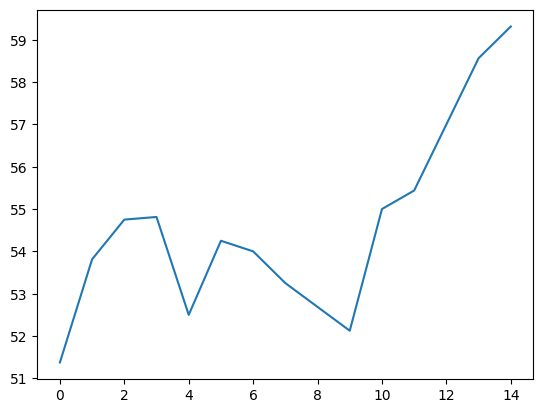

In [46]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss History')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy History')

plt.tight_layout()
plt.show()

# Classification report 

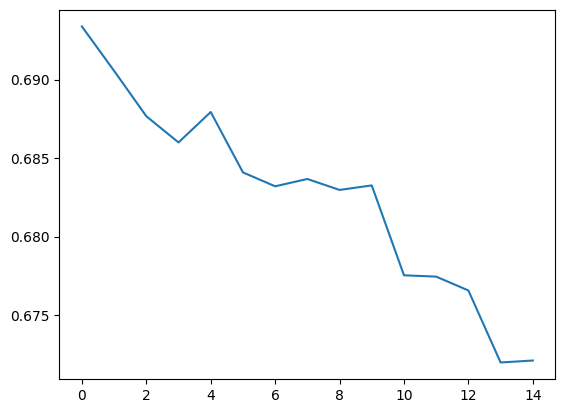

In [47]:
from sklearn.metrics import confusion_matrix, classification_report

# Load the best model weights
model.load_state_dict(torch.load('best_model.pth'))

# Set the model to evaluation mode
model.eval()

# Prepare the test dataset
test_dataset = ImageFolder('/content/Testing', transform=data_transforms)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Initialize lists to store true labels and predicted labels
true_labels = []
pred_labels = []

# Test the model
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(predicted.cpu().numpy())

# Calculate accuracy
accuracy = np.mean(np.array(true_labels) == np.array(pred_labels))
print(f'Test Accuracy: {accuracy:.2%}')

# Print classification report
print(classification_report(true_labels, pred_labels, target_names=test_dataset.classes))

# Print confusion matrix
conf_matrix = confusion_matrix(true_labels, pred_labels)
print('Confusion Matrix:')
print(conf_matrix)


## Model Provider flow

### Authenticate with Nillion

To connect to the Nillion network, we need to have a user key and a node key. These serve different purposes:

The `user_key` is the user's private key. The user key should never be shared publicly, as it unlocks access and permissions to secrets stored on the network.

The `node_key` is the node's private key which is run locally to connect to the network.

In [51]:
# Load all Nillion network environment variables
# assert os.getcwd().endswith(
#     "examples/multi_layer_perceptron"
# ), "Please run this script from the examples/multi_layer_perceptron directory otherwise, the rest of the tutorial may not work"
# load_dotenv()
print(os.getcwd())

/home/brglt/Desktop/nillion/quickstart/nada_quickstart_programs/src


In [14]:
cluster_id = os.getenv("NILLION_CLUSTER_ID")
grpc_endpoint = os.getenv("NILLION_NILCHAIN_GRPC")
chain_id = os.getenv("NILLION_NILCHAIN_CHAIN_ID")
seed = "my_seed"
model_provider_userkey = UserKey.from_seed((seed))
model_provider_nodekey = NodeKey.from_seed((seed))
model_provider_client = create_nillion_client(model_provider_userkey, model_provider_nodekey)
model_provider_party_id = model_provider_client.party_id
model_provider_user_id = model_provider_client.user_id

In [1]:
!pynadac /home/brglt/Desktop/nillion/quickstart/nada_quickstart_programs/src/nn.py

Error: compilation failed

Caused by:
    Traceback (most recent call last):
      File "/home/brglt/miniconda3/envs/ml/lib/python3.12/site-packages/nada_dsl/compile.py", line 43, in compile
        main = getattr(script, "nada_main")
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    AttributeError: module 'nn' has no attribute 'nada_main'
    
    During handling of the above exception, another exception occurred:
    
    Traceback (most recent call last):
      File "/home/brglt/miniconda3/envs/ml/lib/python3.12/site-packages/nada_dsl/compile.py", line 97, in <module>
        output = compile(sys.argv[1])
                 ^^^^^^^^^^^^^^^^^^^^
      File "/home/brglt/miniconda3/envs/ml/lib/python3.12/site-packages/nada_dsl/timer.py", line 116, in wrapper
        value = func(*args, **kwargs)
                ^^^^^^^^^^^^^^^^^^^^^
      File "/home/brglt/miniconda3/envs/ml/lib/python3.12/site-packages/nada_dsl/compile.py", line 45, in compile
        raise Exception(
    Exception: 'nada

In [15]:
party_names = ["Provider", "User"]
program_name = "multi_layer_perceptron"
program_mir_path = f"target/{program_name}.nada.bin"

In [16]:
payments_config = create_payments_config(chain_id, grpc_endpoint)
payments_client = LedgerClient(payments_config)
payments_wallet = LocalWallet(
    PrivateKey(bytes.fromhex(os.getenv("NILLION_NILCHAIN_PRIVATE_KEY_0"))),
    prefix="nillion",
)

### Upload Nada program to Nillion

TODO: explain what the Nada program does

In [17]:
program_id = await store_program(
    model_provider_client,
    payments_wallet,
    payments_client,
    model_provider_user_id,
    cluster_id,
    program_name,
    program_mir_path,
)

Getting quote for operation...
Submitting payment receipt 2 unil, tx hash 32054F2BE5EED437390CDF7A782C6659B8F0C178A398CCF346178E2827C554DB
Stored program. action_id: 3rgqxWd47e171EUwe4RXP9hm45tmoXfuF8fC52S7jcFoQTnU8wPiL7hqWzyV1muak6bEg7iWhudwg4t2pM9XnXcp/multi_layer_perceptron
Stored program_id: 3rgqxWd47e171EUwe4RXP9hm45tmoXfuF8fC52S7jcFoQTnU8wPiL7hqWzyV1muak6bEg7iWhudwg4t2pM9XnXcp/multi_layer_perceptron


### Upload weights to Nillion network

In [18]:
# Create and store model secrets via ModelClient
model_client = TorchClient(my_model)

In [19]:
model_secrets = nillion.NadaValues(
    model_client.export_state_as_secrets("my_nn", na.SecretRational)
)
permissions = nillion.Permissions.default_for_user(model_provider_client.user_id)
permissions.add_compute_permissions({model_provider_client.user_id: {program_id}})

model_store_id = await store_secrets(
    model_provider_client,
    payments_wallet,
    payments_client,
    cluster_id,
    model_secrets,
    1,
    permissions,
)

Getting quote for operation...
Quote cost is 5570 unil
Submitting payment receipt 5570 unil, tx hash 6A9CB2D7060BE85272B383A6F23E71D34B10B87D27F21173004990831868683A


In [20]:
# This information is needed by the model user
with open("data/tmp.json", "w") as provider_variables_file:
    provider_variables = {
        "program_id": program_id,
        "model_store_id": model_store_id,
        "model_provider_party_id": model_provider_party_id,
    }
    json.dump(provider_variables, provider_variables_file)

In [21]:
torch.save(my_model.state_dict(), "./data/my_model.pt")